In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple
import itertools
from copy import copy, deepcopy
import os
import shutil
from functools import reduce

import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient, BlobServiceClient
from azure.core.exceptions import ResourceExistsError

  Using cached opencv_python_headless-4.5.3.56-cp38-cp38-manylinux2014_x86_64.whl (37.1 MB)


In [3]:
####################################
# Read dataset
####################################

# import heat extremes data
fn = f"Ext_max_t__Rgn_1__2015__Abv_Avg_5_K_for_4_days__CMIP6_ssp245_Avg_yrs_1950_79.nc"
ds = xr.open_mfdataset(fn)

print(ds.attrs['Number of continuous days to be considered extreme'], "days")
print(ds.attrs['threshold'], "K above")

4 days
5 K above


In [20]:
# ds

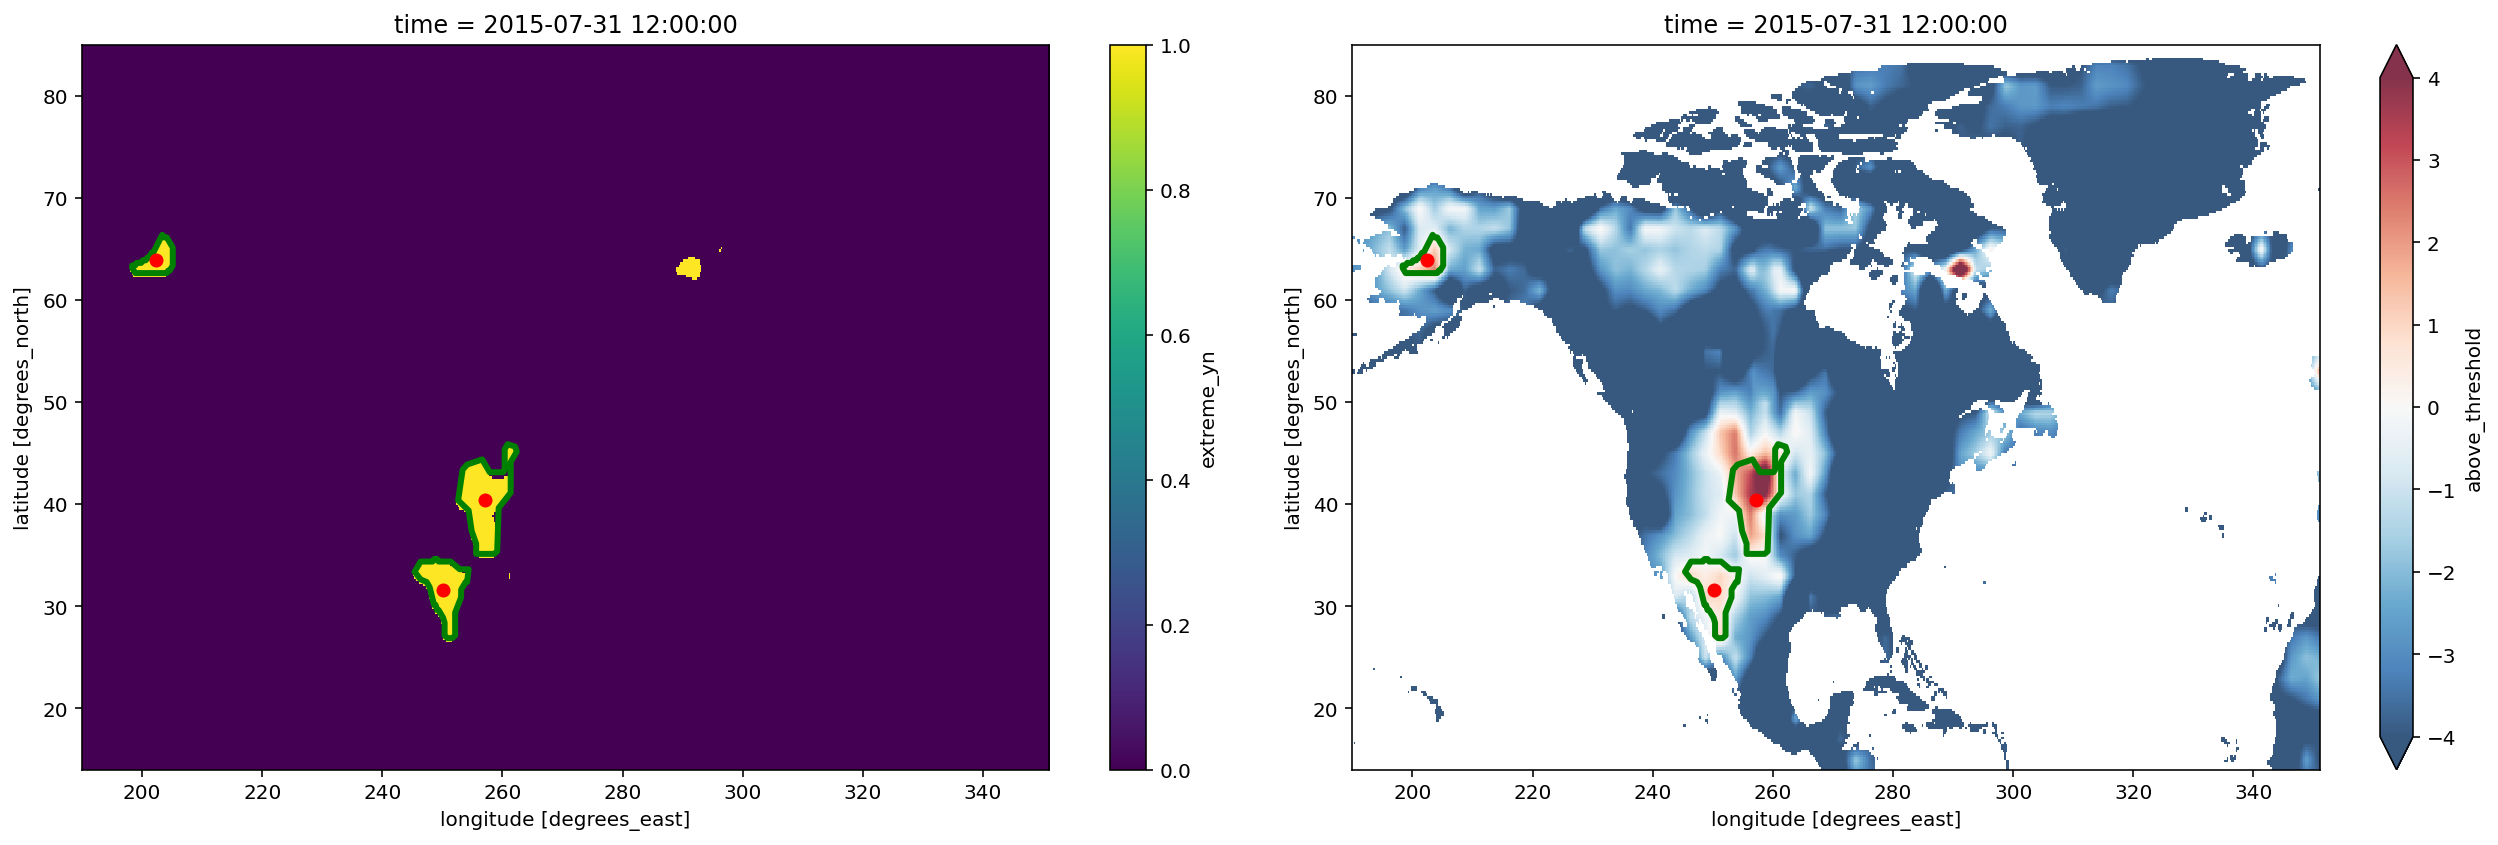

In [42]:
####################################
# NEW bounding-grids algotihm pipeline
####################################

"""
NEW, bounding-contours algorithm to find the extend of the heat events and
produce visualizations. It uses the the heat events y/n dataset 
which was (supposed to be pre-) produced by the "Heatwave Analysis" algorithm. 
"""

def find_contours(arr2d: np.array, extend=False) -> List[np.array]:
    """Encapsulate islands of 1s and return contours, [(i,j),(..),]."""
    H = arr2d.astype(np.uint8)
    ret, thresh = cv2.threshold(H, 0, 1, 0, cv2.THRESH_BINARY)
    
    kernel = np.ones((10,10), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if extend:
        contours = [cv2.convexHull(c) for c in contours]
    contours = [c for c in contours if c.shape[0]>1] # filter single points
    
    return contours

LONS = ds.coords['lon']
LATS = ds.coords['lat']
SMOOTH_RATIO = 0.005
AREA_TRESH = 50
IMG_SHAPE = (ds.dims['lat'], ds.dims['lon'])

 
class Contour():

    def __init__(self, cnt:np.array):
        self.contour = cnt
        self.area = cv2.contourArea(cnt)
        self._smoothened = np.array([], dtype=np.int32)
        self._projected = np.array([], dtype=np.float64)
        self._center = ()
    
    @property
    def smoothened(self):
        cnt = self.contour
        arc = SMOOTH_RATIO*cv2.arcLength(cnt,True)
        return cv2.approxPolyDP(cnt,arc,True)
    
    @property
    def projected(self):
        squeezed = self.smoothened.squeeze()
        proj = [(float(LONS[x]), float(LATS[y])) for (x,y) in squeezed]
        return np.array(proj).reshape((-1,1,2))
    
    @property
    def center(self):
        M = cv2.moments(self.contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return (float(LONS[cX]), float(LATS[cY])) 
        
    def overlaps(self, obj2:object) -> bool:
        """Check if two contour objects overlap."""
        ctrs = [self.contour, obj2.contour]
        zeros = np.zeros(IMG_SHAPE)
        img1 = cv2.drawContours(zeros.copy(), ctrs, 0, 1)
        img2 = cv2.drawContours(zeros.copy(), ctrs, 1, 1)
        intersection = np.logical_and(img1, img2)
        return intersection.any()
    
    def __add__(self, obj2):
        """Fuse two countor objects, if they overlap."""
        if self.overlaps(obj2):
            c1, c2 = self.contour, obj2.contour
            fused = cv2.convexHull(np.vstack([c1, c2]))
            return (self.__class__(fused), )
        else:
            return (self, obj2)
        
####################################
# Visualize
####################################

# store some meta data for easy access
dr = pd.DatetimeIndex(ds['time'].dt.floor('D').values.astype('str'))

# create plot(s)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

# select the day to plot
idx = 211

day = dr[idx].strftime("%Y-%m-%d")
tasmax = ds['tasmax'].sel(time=day)
tdiff = ds['above_threshold'].sel(time=day)
extreme = ds['extreme_yn'].sel(time=day)

im1 = extreme.squeeze().plot.imshow(ax=ax1)
im2 = tdiff.squeeze().plot.imshow(ax=ax2, cmap='RdBu_r', vmin=4, vmax=-4, alpha=0.8)

# find bounding contours
arr2d = extreme.values[0]
contours = find_contours(arr2d, extend=False) 
contours = [Contour(c) for c in contours]
contours = [c for c in contours if c.area>150]

# add these patches on the plot(s)
patches = [Polygon(c.projected.squeeze(), True) for c in contours]

args = dict(edgecolors=("g",), linewidths=(3,), facecolor="none",)
p = PatchCollection(patches, **args)
ax1.add_collection(p)
[ax1.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]
p = PatchCollection(patches, **args)
ax2.add_collection(p)
[ax2.scatter(x=c.center[0], y=c.center[1], c='r') for c in contours]

fig.tight_layout()
